In [1]:
## Try running simulations (starting all from one state) to get better idea of relaxations

import sys, pickle
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, os, pyemma
import pandas as pd, seaborn as sns, argparse


In [2]:
class seqObj:
    
    def __init__(self, seq, temp, state_list, nstates, nmodes, minflux=5e-6):
        
        self.seq = seq
        self.temp = temp
        self.state_list = state_list
        self.nstates = nstates
        self.nmodes = nmodes
        self.minflux = minflux

        msm_path = '../MSM_construction/MSMs/'
        dist_path = '../dna_data/'
        self.meta_dir = f'{msm_path}{seq}_dist_reduced_{temp}K_40-250000-55_micro-200_macro-{nstates}_lag-12_srvlag-12/'
        self.dist_dir = f'{dist_path}{seq}_dist_{temp}K_40-250000-190.npy'
        
seq_dict = {}
seq_dict['AT-all'] =  seqObj(seq='AT-all', temp=309,
                      state_list=['3S4', '5S4', '3S2', '5S2', 'H', 'D'],
                      nstates= 6, nmodes = 5, minflux=5e-6)

seq_dict['GC-end'] =  seqObj(seq='GC-end', temp=317,
                      state_list=['5S4', '3S2', '5S2', 'D', 'H'], 
                      nstates= 5, nmodes = 5, minflux=5e-6)

seq_dict['GC-core'] = seqObj(seq='GC-core', temp=324,
                      state_list=['F4', 'H', 'D'],
                      nstates= 3, nmodes = 3, minflux=5e-6)

seq_dict['GC-mix'] = seqObj(seq='GC-mix', temp=324,
                      state_list=['H', 'D'],
                      nstates= 2, nmodes = 2, minflux=5e-6)


0 3S4 10
1 5S4 17
2 3S2 33
3 5S2 51
4 H 38
5 D 51
(4, 83334)
0 5S4 1
1 3S2 4
2 5S2 12
3 D 114
4 H 69
(3, 83334)


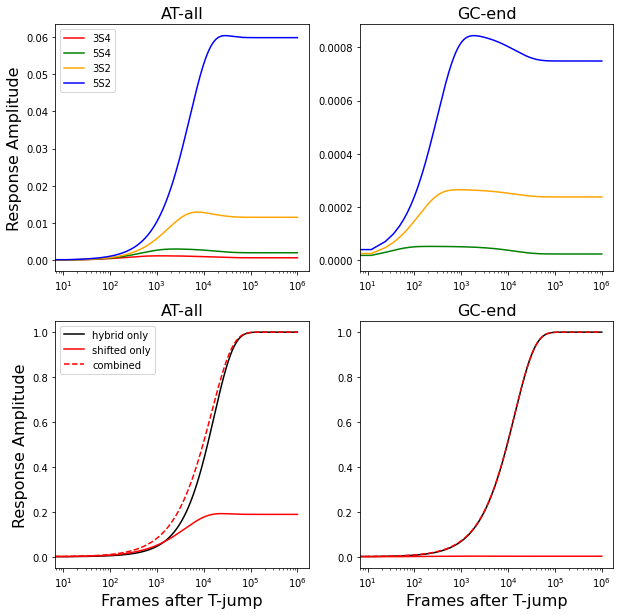

In [5]:
# try dynamical relaxation using method below:
# http://www.emma-project.org/latest/api/generated/pyemma.msm.markov_model.html#pyemma.msm.models.msm.MSM.fingerprint_relaxation
# reference:  Noe, F, S Doose, I Daidone, M Loellmann, M Sauer, J D Chodera and J Smith. 2010. Dynamical fingerprints for probing individual relaxation processes in biomolecular dynamics with simulations and kinetic experiments. PNAS 108 (12): 4822-4827

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fsize = 16

shifted_states = ['3S4', '5S4', '3S2', '5S2']
shifted_colors = {'3S4':'red', '5S4':'green', '3S2':'orange', '5S2':'blue'}
bp_fraction = {'3S4':0.6, '5S4':0.6, '3S2':0.8, '5S2':0.8}

inital_states = shifted_states #['F4', '3S4', '5S4', '3S2', '5S2', 'H']
final_states = ['D']
maxtime = 1e6

for seq_name, ax_row in zip(['AT-all', 'GC-end'], axes.T):

    # load msm data
    seqO = seq_dict[seq_name]
    msm = pickle.load(open(seqO.meta_dir + 'msm_hde.pkl', 'rb'))

    n_micro = msm.nstates
    stationary = msm.stationary_distribution
    
    ones = np.ones(n_micro)
    p0 = np.zeros(n_micro)
    a = np.zeros(n_micro)
    relax_macros = []
    relax_names = []
    for j, (s, state) in enumerate(zip(msm.metastable_sets, seqO.state_list)):
        print(j, state, len(s))
        
        # set a equal H microstate probabilities at stationary
        # iterate through each shifted state to consider independent relaxtion
        if state in shifted_states:
            p0 = np.zeros(n_micro)
            p0[s] = stationary[s]
            relax_macros.append(p0)
            relax_names.append(state)
            
        elif state == 'H':
            p0_hybrid = np.zeros(n_micro)
            p0_hybrid[s] = stationary[s]

        elif state == 'D':
            a[s] = ones[s]
            
    # take norm across all non-D states so that initial probability is 1
    norm = np.sum(relax_macros) + np.sum(p0_hybrid)
    
    # relaxation for each shifted state
    ax = ax_row[0]
    res_list = []
    for p0, name in zip(relax_macros, relax_names):
        times, res = msm.relaxation(bp_fraction[name]*p0/norm, a, maxtime=maxtime)
        ax.plot(times, res, label=name, c=shifted_colors[name])
        res_list.append(res)
        
    ax.set_xscale('log')
    ax.set_title(seqO.seq, fontsize=fsize)
    if seq_name=='AT-all': ax.set_ylabel('Response Amplitude', fontsize=fsize)
    
    # relaxation when combined with the hybridized state
    ax = ax_row[1]
    _, res_hybrid = msm.relaxation(p0_hybrid/norm, a, maxtime=maxtime)
    
    # combine all res from shifted 
    print(np.shape(res_list))
    shifted_res_combined = np.array(res_list).sum(axis=0)
    hybrid_res_combined = res_hybrid+shifted_res_combined
    ax.plot(times, res_hybrid/(res_hybrid[-1]), label='hybrid only', c='black')
    ax.plot(times, shifted_res_combined/(res_hybrid[-1]) , label='shifted only', c='red')
    ax.plot(times, (hybrid_res_combined)/(hybrid_res_combined[-1]) , label='combined', c='red', linestyle='dashed')
    
    ax.set_xscale('log')
    ax.set_xlabel('Frames after T-jump', fontsize=fsize)
    ax.set_title(seqO.seq, fontsize=fsize)
    if seq_name=='AT-all': ax.set_ylabel('Response Amplitude', fontsize=fsize)
    
axes[0, 0].legend()
axes[1, 0].legend()
        
    

In [ ]:
# acquire pwd to quantify fraying behavior across trajs



(200,) 200 0.9999999999999996
0 3S4 10
3 0.00021572238761443695 0.001176226216217585
1 5S4 17
2 0.023891143975091032 0.0035554536128414964
2 3S2 33
26 0.00798217644417342 0.015253847709879599
3 5S2 51
0 0.00015983602491300537 0.07904186950079156
4 H 38
0 0.00015983602491300537 0.41477726064646553
5 D 51
(4, 83334)
(200,) 200 1.0
0 5S4 1
0 0.04133553227897133 5.284138276118656e-05
1 3S2 4
0 0.04133553227897133 0.00040033755438481514
2 5S2 12
9 0.002419357842958453 0.0012596187422647233
3 D 114
4 H 69
0 0.04133553227897133 0.57196484644955
(3, 83334)


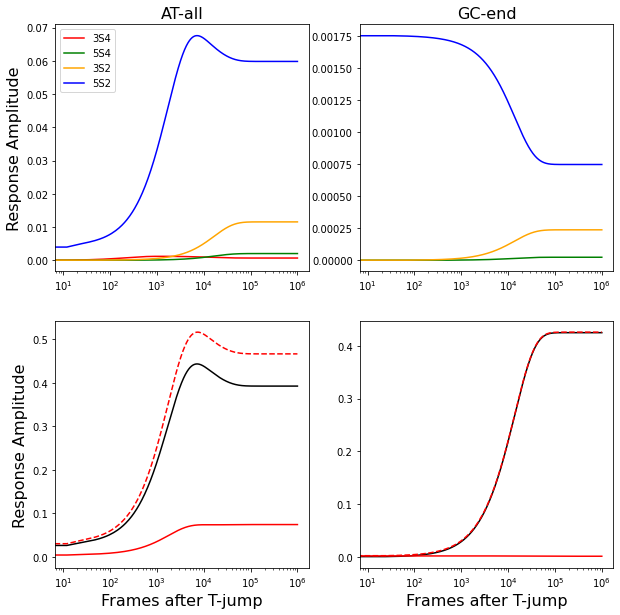

In [6]:
# use only the most populated (stable) microstate for each shifted state

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fsize = 16

shifted_states = ['3S4', '5S4', '3S2', '5S2']
shifted_colors = {'3S4':'red', '5S4':'green', '3S2':'orange', '5S2':'blue'}
bp_fraction = {'3S4':0.6, '5S4':0.6, '3S2':0.8, '5S2':0.8}

inital_states = shifted_states #['F4', '3S4', '5S4', '3S2', '5S2', 'H']
final_states = ['D']
maxtime = 1e6

for seq_name, ax_row in zip(['AT-all', 'GC-end'], axes.T):

    # load msm data
    seqO = seq_dict[seq_name]
    msm = pickle.load(open(seqO.meta_dir + 'msm_hde.pkl', 'rb'))
    
    # can load feature distances to identify microstate populations
    #dists = np.load(seqO.dist_dir)
    #print(dists.shape)

    n_micro = msm.nstates
    stationary = msm.stationary_distribution
    print(np.shape(p0), n_micro, stationary.sum())
    
    ones = np.ones(n_micro)
    p0 = np.zeros(n_micro)
    a = np.zeros(n_micro)
    relax_macros = []
    relax_names = []
    for j, (s, state) in enumerate(zip(msm.metastable_sets, seqO.state_list)):
        print(j, state, len(s))
        
        # set a equal H microstate probabilities at stationary
        # iterate through each shifted state to consider independent relaxtion
        if state in shifted_states:
            p0 = np.zeros(n_micro)
            max_s = np.argmax(stationary[s])
            print(max_s, stationary[max_s], stationary[s].sum())
            p0[max_s] = stationary[s].sum()
            relax_macros.append(p0)
            relax_names.append(state)
            
        elif state == 'H':
            p0_hybrid = np.zeros(n_micro)
            max_s = np.argmax(stationary[max_s])
            print(max_s, stationary[max_s], stationary[s].sum())
            state_norm = stationary[max_s] / stationary[s].sum()
            p0_hybrid[max_s] = stationary[s].sum()

        elif state == 'D':
            a[s] = ones[s]
            
    # take norm across all non-D states so that initial probability is 1
    norm = np.sum(relax_macros) + np.sum(p0_hybrid)
    
    # relaxation for each shifted state
    ax = ax_row[0]
    res_list = []
    for p0, name in zip(relax_macros, relax_names):
        times, res = msm.relaxation(bp_fraction[name]*p0/norm, a, maxtime=maxtime)
        ax.plot(times, res, label=name, c=shifted_colors[name])
        res_list.append(res)
        
    ax.set_xscale('log')
    ax.set_title(seqO.seq, fontsize=fsize)
    if seq_name=='AT-all': ax.set_ylabel('Response Amplitude', fontsize=fsize)
    
    # relaxation when combined with the hybridized state
    ax = ax_row[1]
    _, res_hybrid = msm.relaxation(p0_hybrid/norm, a, maxtime=maxtime)
    
    # combine all res from shifted 
    print(np.shape(res_list))
    shifted_res_combined = np.array(res_list).sum(axis=0)
    ax.plot(times, res_hybrid, label='hybrid only', c='black')
    ax.plot(times, shifted_res_combined , label='shifted only', c='red')
    ax.plot(times, res_hybrid+shifted_res_combined , label='combined', c='red', linestyle='dashed')
    
    ax.set_xscale('log')
    ax.set_xlabel('Frames after T-jump', fontsize=fsize)
    if seq_name=='AT-all': ax.set_ylabel('Response Amplitude', fontsize=fsize)
    
axes[0, 0].legend()
        
    

In [ ]:
#times, res = msm.relaxation(p0, a, maxtime=maxtime)
#ax.plot(times, res)

# fingerprint relaxation
#timescales, amplitudes = msm.fingerprint_relaxation(p0, a)
#ax.scatter(timescales, amplitudes)